In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Détection du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 1. Chargement et Prétraitement des Données
# Les images CIFAR-10 sont converties en tenseurs (leurs valeurs sont déjà mises à l'échelle entre 0 et 1 par ToTensor)
transform = transforms.ToTensor()

# Chargement du dataset CIFAR-10 (train et test)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# On sépare le jeu d'entraînement en train et validation (80%-20%).
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Liste des classes
class_names = ['avion', 'automobile', 'oiseau', 'chat', 'cerf',
               'chien', 'grenouille', 'cheval', 'bateau', 'camion']

In [ ]:
# 2. Création du Modèle (CNN)
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        # Bloc 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        # Bloc 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        # Couches entièrement connectées
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # CIFAR-10: 32x32 -> pool1 réduit à 16x16, pool2 à 8x8
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Bloc 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        # Bloc 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        # Couches entièrement connectées
        x = self.flatten(x)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)  # On renvoie les logits (pas de softmax ici, car CrossEntropyLoss s'en charge)
        return x

model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_featu

In [ ]:
# 3. Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mise en place d'un early stopping simple
patience = 10
best_val_acc = 0.0
epochs_without_improvement = 0
num_epochs = 50

In [ ]:
# 4. Entraînement du Modèle
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Les labels sont déjà des indices entiers (pas one-hot)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Validation Accuracy: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping déclenché.")
            break

# Charger les meilleurs poids enregistrés
model.load_state_dict(best_model_wts)

Epoch 1/50 - Loss: 1.2582 - Validation Accuracy: 0.6736
Epoch 2/50 - Loss: 0.9071 - Validation Accuracy: 0.7047
Epoch 3/50 - Loss: 0.7888 - Validation Accuracy: 0.7371
Epoch 4/50 - Loss: 0.7002 - Validation Accuracy: 0.7632
Epoch 5/50 - Loss: 0.6350 - Validation Accuracy: 0.7830
Epoch 6/50 - Loss: 0.5859 - Validation Accuracy: 0.7913
Epoch 7/50 - Loss: 0.5358 - Validation Accuracy: 0.7946
Epoch 8/50 - Loss: 0.4961 - Validation Accuracy: 0.7909
Epoch 9/50 - Loss: 0.4541 - Validation Accuracy: 0.8032
Epoch 10/50 - Loss: 0.4267 - Validation Accuracy: 0.8142
Epoch 11/50 - Loss: 0.3926 - Validation Accuracy: 0.8097
Epoch 12/50 - Loss: 0.3630 - Validation Accuracy: 0.8173
Epoch 13/50 - Loss: 0.3392 - Validation Accuracy: 0.8135
Epoch 14/50 - Loss: 0.3199 - Validation Accuracy: 0.8197
Epoch 15/50 - Loss: 0.3028 - Validation Accuracy: 0.8213
Epoch 16/50 - Loss: 0.2799 - Validation Accuracy: 0.8266
Epoch 17/50 - Loss: 0.2697 - Validation Accuracy: 0.8317
Epoch 18/50 - Loss: 0.2521 - Validation 

<All keys matched successfully>

In [ ]:
# 5. Évaluation du Modèle sur le Jeu de Test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total
print("Test Loss  :", avg_test_loss)
print("Test Accuracy  :", test_acc)

Test Loss  : 0.6744320723851016
Test Accuracy  : 0.8315


In [ ]:
# 6. Réalisation de Prédictions sur Quelques Images du Jeu de Test
model.eval()
# Sélectionner 5 images du jeu de test
dataiter = iter(test_loader)
images, labels = dataiter.__next__()
images = images[:5].to(device)
outputs = model(images)
# Appliquer softmax pour obtenir des probabilités
probabilities = F.softmax(outputs, dim=1).detach().cpu().numpy()
print("Prédictions (probabilités) pour les 5 premières images :")
print(np.round(probabilities, 3))

Prédictions (probabilités) pour les 5 premières images :
[[0.    0.    0.    0.946 0.    0.054 0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.    0.    0.    0.999 0.   ]
 [0.004 0.019 0.    0.    0.    0.    0.    0.    0.973 0.005]
 [0.293 0.102 0.    0.    0.    0.    0.    0.    0.585 0.02 ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]]


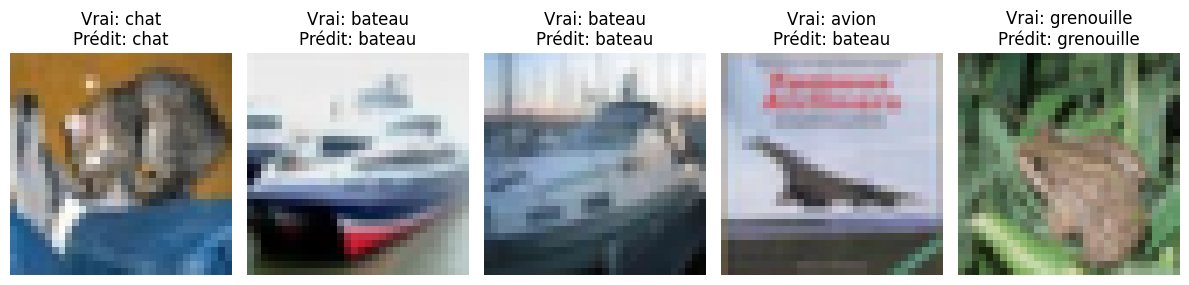

In [ ]:
# Visualisation
images = images.cpu().numpy()
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Les images sont au format (C, H, W); on transpose pour matplotlib
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    true_label = class_names[labels[i]]
    pred_label = class_names[np.argmax(probabilities[i])]
    plt.title(f"Vrai: {true_label}\nPrédit: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# 7. Sauvegarde du modèle
torch.save(model.state_dict(), 'mon_modele.pth')